In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report, recall_score

In [14]:
df_resultados = pd.read_csv('RESULTADOS_04_06_2024_full_teste.csv', compression='gzip')
df_resultados2 = pd.read_csv('RESULTADOS_02_03_2024_full_teste.csv', compression='gzip')
df_resultados3 = pd.read_csv('RESULTADOS_06_2023_07_2023_full_teste.csv' ,compression='gzip')

In [15]:
# Remover coluna errada
df_resultados = df_resultados.drop(columns=['Unnamed: 0'], axis=1)
df_resultados2 = df_resultados2.drop(columns=['Unnamed: 0'], axis=1)
df_resultados3 = df_resultados3.drop(columns=['Unnamed: 0'], axis=1)


In [16]:
df_resultados = df_resultados.dropna()
df_resultados2 = df_resultados2.dropna()
df_resultados3 = df_resultados3.dropna()

In [17]:
# Transformando para .parquet para uma manipulação mais rápida dos dados

df_resultados.to_parquet('df_resultados.parquet', index=False)
df_resultados2.to_parquet('df_resultados2.parquet', index=False)
df_resultados3.to_parquet('df_resultados3.parquet', index=False)

In [18]:
# Limpando colunas que não serão usadas agora

colunas = ['UNIT', 'VALUE_ID', 'VALUE', 'DATA']

df_resultados2 = df_resultados2.drop(columns=colunas, axis=1)
df_resultados = df_resultados.drop(columns=colunas, axis=1)
df_resultados3 = df_resultados3.drop(columns=colunas, axis=1)

In [19]:
# Transformando os DFs de resultados em apenas um DF de resultados maior

df = pd.concat([df_resultados, df_resultados2, df_resultados3])

In [23]:
df.head()

,KNR,NAME,ID,STATUS
6,2023-2056234,042000,1,10
7,2023-2056234,042000,1,10
8,2023-2056234,042000,1,10
9,2023-2056234,042000,1,10
10,2023-2056234,042000,1,10


In [25]:
status_count = df.groupby(['KNR', 'ID', 'STATUS']).size().unstack(fill_value=0)

# Pivot the table to create columns for each ID-STATUS combination
status_count = status_count.unstack(level=-1).fillna(0)

# Flatten the column MultiIndex
status_count.columns = [f'{int(col[1])}_status_{int(col[0])}' for col in status_count.columns]

# Reset index to bring KNR back as a column
status_count = status_count.reset_index()

# Group by KNR and calculate the count of unique names
unique_names = df.groupby('KNR').agg(unique_names=('NAME', 'nunique')).reset_index()

# Merge the unique names count with the status counts
resultados_id_status = pd.merge(unique_names, status_count, on='KNR')

In [28]:
resultados_id_status.head()

,KNR,unique_names,1_status_10,2_status_10,718_status_10,1_status_13,2_status_13,718_status_13
0,2023-2016173,3,0.0,12.0,1.0,0.0,0.0,1.0
1,2023-2026098,3,0.0,8.0,1.0,0.0,0.0,0.0
2,2023-2026162,3,0.0,8.0,1.0,0.0,0.0,0.0
3,2023-2026175,3,0.0,8.0,1.0,0.0,0.0,0.0
4,2023-2026215,3,0.0,8.0,1.0,0.0,0.0,0.0


# Falhas

In [41]:
falhas = pd.read_csv('falhas_modelo.csv')

/tmp/ipykernel_265331/3729996659.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  falhas = pd.read_csv('falhas_modelo.csv')


In [42]:
falhas = falhas.drop(['day', 'month', 'year', 'hour', 'minute', 'second', 'MODELO', 'COR', 'MOTOR', 'ESTACAO', 'USUARIO', 'FALHA'], axis=1)

In [43]:
# Primeiro, remove a coluna 'HALLE'
falhas = falhas.drop(columns=['HALLE'])

# Faz o pivot do DataFrame para criar colunas para cada S_GROUP_ID único
falhas_pivot = pd.get_dummies(falhas, columns=['S_GROUP_ID'])

# Agrupa por KNR para garantir que os valores de KNR sejam únicos, somando as variáveis dummy
falhas_grouped = falhas_pivot.groupby('KNR').sum().reset_index()

# Exibe o DataFrame transformado final
falhas_grouped


,KNR,S_GROUP_ID_-2,S_GROUP_ID_1,S_GROUP_ID_2,S_GROUP_ID_4,S_GROUP_ID_5,S_GROUP_ID_133,S_GROUP_ID_137,S_GROUP_ID_140,S_GROUP_ID_9830946,S_GROUP_ID_#MULTIVALUE,S_GROUP_ID_-2,S_GROUP_ID_1,S_GROUP_ID_133,S_GROUP_ID_137,S_GROUP_ID_140,S_GROUP_ID_2,S_GROUP_ID_4,S_GROUP_ID_5,S_GROUP_ID_9830946
0,2023-2056234,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,2,1,1
1,2023-2316417,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,2023-2316420,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,2023-3016123,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0
4,2023-3016194,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,7,2,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87400,2024-3516493,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
87401,2024-3716001,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
87402,2024-3716002,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
87403,2024-3876001,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [44]:
# Realiza o merge com base em KNR, usando 'left' join para manter todas as linhas de resultados_id_status
merged_df = pd.merge(resultados_id_status, falhas_grouped, on='KNR', how='left')

# Preenche as colunas S_GROUP_ID faltantes com 0 onde falhas_grouped não teve KNRs correspondentes
merged_df.fillna(0, inplace=True)

# Adiciona a coluna FALHA, 1 se KNR estiver em ambos os DataFrames, caso contrário 0
merged_df['FALHA'] = merged_df['KNR'].apply(lambda x: 1 if x in falhas_grouped['KNR'].values else 0)

# Remove as linhas onde KNR está apenas em falhas_grouped (este passo agora é redundante devido ao 'left' join, 
# mas pode ser adicionado se necessário para lógica adicional)
# merged_df = merged_df[merged_df['KNR'].isin(resultados_id_status['KNR'])]

# Exibe o DataFrame final
merged_df

,KNR,unique_names,1_status_10,2_status_10,718_status_10,1_status_13,2_status_13,718_status_13,S_GROUP_ID_-2,S_GROUP_ID_1,...,S_GROUP_ID_-2,S_GROUP_ID_1,S_GROUP_ID_133,S_GROUP_ID_137,S_GROUP_ID_140,S_GROUP_ID_2,S_GROUP_ID_4,S_GROUP_ID_5,S_GROUP_ID_9830946,FALHA
0,2023-2016173,3,0.0,12.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,2023-2026098,3,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2023-2026162,3,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,2023-2026175,3,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,2023-2026215,3,0.0,8.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49186,2024-2976009,26,0.0,72.0,0.0,0.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
49187,2024-2976010,26,0.0,72.0,0.0,0.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
49188,2024-2976011,26,0.0,74.0,0.0,0.0,0.0,0.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
49189,2024-2976012,26,0.0,82.0,0.0,0.0,0.0,0.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [45]:
falha_counts = merged_df['FALHA'].value_counts()
falha_counts

FALHA
1    40152
0     9039
Name: count, dtype: int64

In [51]:
# Features a serem usadas para previsão
features = ['unique_names', '1_status_10', '2_status_10', '718_status_10',
            '1_status_13', '2_status_13', '718_status_13']
target = 'FALHA'

# Selecionando as features e a variável alvo do DataFrame unificado
X = merged_df[features]
y = merged_df[target].values

# Garantir que `y` seja um array 1D com valores binários (0, 1)
y = y.reshape(-1)  # Achatar para garantir que seja um array 1D

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar as features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Construir o modelo de rede neural Keras
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo
model.fit(X_train_scaled, y_train, epochs=500, batch_size=16, validation_split=0.2)

# Avaliar o modelo no conjunto de teste
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)
print(f'Acurácia no Teste: {test_acc:.4f}')


Epoch 1/500


/home/fillmore/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1968/1968 ━━━━━━━━━━━━━━━━━━━━ 1s 297us/step - accuracy: 0.8519 - loss: 0.3437 - val_accuracy: 0.8798 - val_loss: 0.2537
Epoch 2/500
1968/1968 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - accuracy: 0.8810 - loss: 0.2488 - val_accuracy: 0.8859 - val_loss: 0.2439
Epoch 3/500
1968/1968 ━━━━━━━━━━━━━━━━━━━━ 1s 286us/step - accuracy: 0.8857 - loss: 0.2400 - val_accuracy: 0.8973 - val_loss: 0.2327
Epoch 4/500
1968/1968 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step - accuracy: 0.8919 - loss: 0.2299 - val_accuracy: 0.8970 - val_loss: 0.2245
Epoch 5/500
1968/1968 ━━━━━━━━━━━━━━━━━━━━ 1s 274us/step - accuracy: 0.8948 - loss: 0.2229 - val_accuracy: 0.9013 - val_loss: 0.2227
Epoch 6/500
1968/1968 ━━━━━━━━━━━━━━━━━━━━ 1s 272us/step - accuracy: 0.8974 - loss: 0.2170 - val_accuracy: 0.8971 - val_loss: 0.2147
Epoch 7/500
1968/1968 ━━━━━━━━━━━━━━━━━━━━ 1s 270us/step - accuracy: 0.8994 - loss: 0.2118 - val_accuracy: 0.8989 - val_loss: 0.2148
Epoch 8/500
1968/1968 ━━━━━━━━━━━━━━━━━━━━ 1s 266us/step - accuracy: 0.9029 - los

308/308 ━━━━━━━━━━━━━━━━━━━━ 0s 187us/step


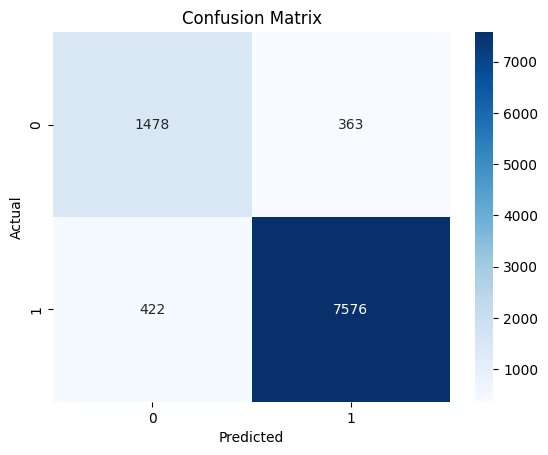

Recall: 0.9472


In [50]:
# Realizar previsões no conjunto de teste
y_pred = (model.predict(X_test_scaled) > 0.5).astype("int32")

# Calcular a matriz de confusão
cm = confusion_matrix(y_test, y_pred)

# Exibir a matriz de confusão
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Calcular o recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')


In [ ]:
torch.save(model.state_dict(), 'model.pt')